<a href="https://colab.research.google.com/github/LourdesBranchi/Embryoxite-Entrevista/blob/main/Embryoxite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/elmerfer/DataLabLearningSeries.git

Cloning into 'DataLabLearningSeries'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 173 (delta 73), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 1.74 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from scipy.stats import linregress
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Input, MultiHeadAttention, Dense, BatchNormalization, Activation, Dropout, Conv1D, Flatten, Attention, LayerNormalization, Reshape, Input
from sklearn.model_selection import train_test_split
import os

# Extraer datos sin procesar

In [3]:
data_path = '/content/DataLabLearningSeries/BatchNormalization layer as Input Layer/Urea.csv'

In [4]:
data = pd.read_csv(data_path)

print(f'El archivo Urea.csv tiene {data.shape[0]} muestras y {data.shape[1]} features para cada muestra')
print(f'Por cada muestra, el archivo CSV contiene la siguiente información:\n{data.columns}')

El archivo Urea.csv tiene 129 muestras y 11 features para cada muestra
Por cada muestra, el archivo CSV contiene la siguiente información:
Index(['Upre', 'U120', 'Upos', 'PP', 'UF', 'Ueq', 'Uann', 'centro', 'Req',
       'Uf/pp', 'Ktveq'],
      dtype='object')


In [5]:
rows_to_eliminate = data.loc[data['Ueq'] < data['Upos']]

if not rows_to_eliminate.empty:
    print("In the following samples Ueq is lower than Upos:")
    display(rows_to_eliminate)
else:
    print("Every Ueq value is equal or higher to Upos.")

print(f"\nThere are {len(rows_to_eliminate)} samples where Ueq is lower than Upos.")

In the following samples Ueq is lower than Upos:


,Upre,U120,Upos,PP,UF,Ueq,Uann,centro,Req,Uf/pp,Ktveq
8,123,68,51,76.9,3.2,49.0,50.4,1,0.398374,0.041612,1.120819
20,157,92,96,67.3,4.3,77.0,89.1,1,0.490446,0.063893,0.941477
23,122,99,93,88.5,5.5,86.0,87.9,1,0.704918,0.062147,0.513294
29,207,76,55,61.7,2.0,51.0,63.3,1,0.246377,0.032415,1.645721
31,137,84,72,119.0,4.1,63.0,56.0,1,0.459854,0.034454,0.939257
32,142,117,80,85.3,2.2,78.0,83.3,1,0.549296,0.025791,0.719805
43,112,49,38,86.0,3.0,35.0,49.4,1,0.312500,0.034884,1.378013
46,165,90,71,80.0,1.0,66.0,63.9,1,0.400000,0.012500,1.034672
50,133,68,49,65.0,2.0,46.0,50.4,1,0.345865,0.030769,1.249944
53,69,28,30,64.5,2.5,20.0,49.3,1,0.289855,0.038760,1.476692



There are 20 samples where Ueq is lower than Upos.


In [6]:
clean_data = data.drop(rows_to_eliminate.index)

if len(clean_data) != len(data):
    print(f'Se eliminaron {len(rows_to_eliminate)}')
    print(f'El DataFrame nuevo tiene {len(clean_data)} filas')
else:
    print('No se eliminaron filas')

Se eliminaron 20
El DataFrame nuevo tiene 109 filas


Se dividen los datos en las variables de entrada (X) y la variable que queremos predecir (y_ueq)

In [8]:
X = clean_data[['Upre', 'U120', 'Upos', 'PP', 'UF']] #Variables de entrada

y_ueq = clean_data['Ueq'] #Variable de salida

# Entrenamiento

El modelo original presentado en el paper utiliza una capa de Batch Normalization (BN) como capa de entrada, seguida por capas completamente conectadas (Fully Connected Layers, FCL). En un ejercicio propuesto, se solicitó reemplazar estas FCL por capas convolucionales (CC) o capas atencionales (CA) para explorar diferentes arquitecturas.

In [9]:
def build_model_BN(tipo_capa, num_capas_ocultas, num_nodos_por_capa, funcion_activacion, activacion_salida):
    model = Sequential()

    # Añadir capa de Batch Normalization
    print(X.shape[1])
    model.add(BatchNormalization(input_shape=(X.shape[1],)))

    for i in range(num_capas_ocultas):
      if tipo_capa == 'FCL':
        # Añadir capa oculta con el número de nodos especificado y la función de activación correspondiente
        model.add(Dense(num_nodos_por_capa))
      elif tipo_capa == 'Conv1D':
        model.add(Reshape((X.shape[1], 1)))
        # Añadir capa convolucional 1D con el número de filtros especificado y la función de activación correspondiente
        model.add(Conv1D(filters=32, kernel_size=2, activation=funcion_activacion, padding='same'))

      model.add(BatchNormalization())
      if tipo_capa == 'Conv1D':
        model.add(Flatten())
      model.add(Activation(funcion_activacion))

    model.add(Dense(1, activation=activacion_salida))  # Capa de salida con función de activación lineal o relu
    return model

## Fully Connected Layer
Este sería el modelo original presentado

In [11]:
# Path to store model checkpoints
checkpoint_path = "/content/drive/MyDrive/Embryoxite/original_model_checkpoints"

# Path to store results
results_path = "/content/drive/MyDrive/Embryoxite/original_model_checkpoints/results.pickle"

# Define optimizer
optimizer = 'SGD'

# Define metric for compile (Mean Squared Error)
metric = 'mean_squared_error'

# Define number of splits
num_splits = 10

# Define empty list to store results
results_original = []

for i in range(num_splits):

    print(i)

    X_t, X_test, y_t, y_test = train_test_split(X, y_ueq, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2)


    DLNNe2e = build_model_BN(tipo_capa='FCL', num_capas_ocultas=1, num_nodos_por_capa=6, funcion_activacion='sigmoid',activacion_salida='linear')
    DLNNe2e.compile(optimizer=optimizer, loss=metric)

    input_shape = (None, X_train.shape[1])
    DLNNe2e.build(input_shape)

    # Train model with early stopping
    history = DLNNe2e.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Save model
    DLNNe2e.save(os.path.join(checkpoint_path, f"DLNNe2e_{i}.h5"))

    # Make predictions
    predictions_DLNNe2e = DLNNe2e.predict(X_test).flatten()

    # Calculate errors
    errors_end_lineal = predictions_DLNNe2e - y_test

    weights_first_layer = DLNNe2e.layers[1].get_weights()[0]

    bn_layer = DLNNe2e.layers[0]
    mu = bn_layer.moving_mean.numpy()
    sd = np.sqrt(bn_layer.moving_variance.numpy())
    beta = bn_layer.beta.numpy()
    gamma = bn_layer.gamma.numpy()
    parametres = [mu, sd, beta, gamma]

    # Store relevant information in a dictionary for DLNNe2e model
    result = {}
    result['split'] = {'train_indices': X_train.index.tolist(), 'test_indices': X_test.index.tolist(), 'val_indices': X_val.index.tolist()}
    result['hidden_layer_weights'] = weights_first_layer
    result['bn_layer_params'] = parametres
    result['mean_prediction_error'] = np.mean(errors_end_lineal)
    result['std_prediction_error'] = np.std(errors_end_lineal)
    result['mean_percentage_error'] = np.mean((errors_end_lineal / y_test) * 100)
    result['std_percentage_error'] = np.std((errors_end_lineal / y_test) * 100)
    result['predictions'] = predictions_DLNNe2e
    result['true_value'] = y_test

    # Agregar los diccionarios a la lista de resultados
    results_original.append({'DLNNe2e': result})

# Guardar los resultados en un archivo pickle
with open(results_path, 'wb') as f:
    pickle.dump(results_original, f)

0
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
3
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
4
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5
5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6
5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
7
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
8
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
9
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


## Capa Convolucional

In [12]:
# Path to store model checkpoints
checkpoint_conv_path = "/content/drive/MyDrive/Embryoxite/conv_model_checkpoints"

# Path to store results
results_conv_path = "/content/drive/MyDrive/Embryoxite/conv_model_checkpoints/results.pickle"

In [13]:
# Define optimizer
optimizer = 'SGD'

# Define metric for compile (Mean Squared Error)
metric = 'mean_squared_error'

# Define number of splits
num_splits = 10

# Define empty list to store results
results_conv = []

for i in range(num_splits):

    print(i)

    X_t, X_test, y_t, y_test = train_test_split(X, y_ueq, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2)

    conv = build_model_BN(tipo_capa='Conv1D', num_capas_ocultas=1, num_nodos_por_capa=2, funcion_activacion='sigmoid',activacion_salida='linear')
    conv.compile(optimizer=optimizer, loss=metric)

    input_shape = (None, X_train.shape[1])
    conv.build(input_shape)
    # Train model with early stopping
    history = conv.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Save model
    conv.save(os.path.join(checkpoint_conv_path, f"conv_{i}.h5"))

    # Make predictions
    predictions_conv = conv.predict(X_test).flatten()

    # Calculate errors
    errors_end_lineal = predictions_conv - y_test

    weights_first_layer = conv.layers[2].get_weights()[0] #La capa de la hidden layer en este caso es 2, por el reshape

    bn_layer = conv.layers[0] #La capa de BN de interes es siempre la capa 0
    mu = bn_layer.moving_mean.numpy()
    sd = np.sqrt(bn_layer.moving_variance.numpy())
    beta = bn_layer.beta.numpy()
    gamma = bn_layer.gamma.numpy()
    parametres = [mu, sd, beta, gamma]

    # Store relevant information in a dictionary for conv model
    result = {}
    result['split'] = {'train_indices': X_train.index.tolist(), 'test_indices': X_test.index.tolist(), 'val_indices': X_val.index.tolist()}
    result['hidden_layer_weights'] = weights_first_layer
    result['bn_layer_params'] = parametres
    result['mean_prediction_error'] = np.mean(errors_end_lineal)
    result['std_prediction_error'] = np.std(errors_end_lineal)
    result['mean_percentage_error'] = np.mean((errors_end_lineal / y_test) * 100)
    result['std_percentage_error'] = np.std((errors_end_lineal / y_test) * 100)
    result['predictions'] = predictions_conv
    result['true_value'] = y_test

    # Agregar los diccionarios a la lista de resultados
    results_conv.append({'conv': result})

# Guardar los resultados en un archivo pickle
with open(results_conv_path, 'wb') as f:
    pickle.dump(results_conv, f)

0
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
4
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
5
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
6
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
7
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
8
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
9
5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


## Capa de Atención

In [33]:
def build_model_atencion(funcion_activacion, activacion_salida):
    # Definir entrada
    inputs = Input(shape=(5,))

    # Añadir Batch Normalization al inicio
    bn_output = BatchNormalization()(inputs)

    # Agregar una dimensión extra: (batch_size, timesteps=5, features=1)
    reshaped = Reshape((5, 1))(bn_output)
    # Aplicar atención (self-attention: Query, Key y Value son la misma entrada)
    mha_layer = MultiHeadAttention(num_heads=1, key_dim=1) #Establecer num_heads = 1 es hacer Self-Attention
    attention_output, attention_scores = mha_layer(query=reshaped, value=reshaped, key=reshaped, return_attention_scores=True)

    # Normalización después de la atención
    norm_output = BatchNormalization()(attention_output)

    # Aplanar salida
    flat_output = Flatten()(norm_output)

    # Activación
    activated_output = Activation(funcion_activacion)(flat_output)

    # Capa de salida
    output = Dense(1, activation=activacion_salida)(activated_output)

    # Definir modelo
    model = Model(inputs=inputs, outputs=[output, attention_scores])

    return model

In [15]:
# Path to store model checkpoints
checkpoint_atencion_path = "/content/drive/MyDrive/Embryoxite/atencion_model_checkpoints"

# Path to store results
results_atencion_path = "/content/drive/MyDrive/Embryoxite/atencion_model_checkpoints/results.pickle"

In [37]:
# Define optimizer
optimizer = 'SGD'

# Define metric for compile (Mean Squared Error)
metric = 'mean_squared_error'

# Define number of splits
num_splits = 10

# Define empty list to store results
results_atencion = []

for i in range(num_splits):

    print(i)

    X_t, X_test, y_t, y_test = train_test_split(X, y_ueq, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2)

    dummy_attention_targets = np.zeros((X_train.shape[0], 1, 5, 5))  # Dummy target para los attention scores
    dummy_attention_targets_val = np.zeros((X_val.shape[0], 1, 5, 5))

    atencion = build_model_atencion(funcion_activacion='sigmoid',activacion_salida='linear')
    atencion.compile(optimizer=optimizer, loss=[metric, lambda y_true, y_pred: tf.zeros_like(y_pred)])

    # Train model with early stopping
    history = atencion.fit(X_train, [y_train, dummy_attention_targets], epochs=200, batch_size=32, verbose=0, validation_data=(X_val, [y_val, dummy_attention_targets_val]))

    # Save model
    atencion.save(os.path.join(checkpoint_atencion_path, f"atencion_{i}.h5"))

    # Make predictions
    predictions_atencion, att_scores = atencion.predict(X_test)
    predictions_atencion = predictions_atencion.flatten()

    # Calculate errors
    errors_end_lineal = predictions_atencion - y_test

    weights_first_layer = atencion.layers[4].get_weights()[0] #La capa de la hidden layer en este caso es 2, por el reshape

    bn_layer = atencion.layers[1] #La capa de BN de interes es siempre la capa 0
    mu = bn_layer.moving_mean.numpy()
    sd = np.sqrt(bn_layer.moving_variance.numpy())
    beta = bn_layer.beta.numpy()
    gamma = bn_layer.gamma.numpy()
    parametres = [mu, sd, beta, gamma]

    # Store relevant information in a dictionary for atencion model
    result = {}
    result['split'] = {'train_indices': X_train.index.tolist(), 'test_indices': X_test.index.tolist(), 'val_indices': X_val.index.tolist()}
    result['hidden_layer_weights'] = weights_first_layer
    result['bn_layer_params'] = parametres
    result['mean_prediction_error'] = np.mean(errors_end_lineal)
    result['std_prediction_error'] = np.std(errors_end_lineal)
    result['mean_percentage_error'] = np.mean((errors_end_lineal / y_test) * 100)
    result['std_percentage_error'] = np.std((errors_end_lineal / y_test) * 100)
    result['predictions'] = predictions_atencion
    result['true_value'] = y_test
    result['attention_scores'] = att_scores

    # Agregar los diccionarios a la lista de resultados
    results_atencion.append({'atencion': result})

# Guardar los resultados en un archivo pickle
with open(results_atencion_path, 'wb') as f:
    pickle.dump(results_atencion, f)

0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
4


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
6


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
7


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
8


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


# Uso de capa convolucional vs capa atencional

Dado el problema de regresión en el cual se estima el valor de Ueq, tomando en cuenta la concentración de urea previa, 120 minutos después de comenzar, y post-hemodiálisis, así como las variables de PP y UF, se solicitó analizar el uso de una capa convolucional o atencional en lugar de una capa densa.

## Capa convolucional

Las capas convolucionales están diseñadas para extraer patrones locales aprovechando una estructura de orden en los datos, como es el caso de imágenes o series temporales. En este caso, el conjunto de datos, en principio, no posee un orden intrínseco, es decir, no existe una relación de vecindad entre las variables de entrada. Es por esto que el utilizar una capa convolucional en este caso carece de sentido.

Si existen combinaciones particulares de features que aporten valor a la estimación que se busca, se podría imponer un orden arbitrario. En ese caso, tendría más sentido utilizar este tipo de capa. De todas formas, al tener únicamente 5 variables de entrada, el potencial de capturar patrones locales mediante una convolución es reducido. Para que tenga sentido, se debería aumentar la cantidad de variables en la entrada y además, imponer un orden en caso de que se pueda.

## Capa de atención

Las capas de atención son especialmente útiles en problemas donde la entrada se presenta como una secuencia y se requiere analizar el contexto y las interrelaciones entre sus elementos, incluso cuando estos se encuentran distanciados dentro de la misma. Estas capas permiten capturar relaciones complejas e interacciones entre las variables de entrada, lo que puede mejorar la predicción de la variable de salida. De esta forma, se obtiene un mayor entendimiento sobre las combinaciones de features más relevantes para la estimación deseada.

En el contexto específico del problema planteado, tiene sentido usar capas atencionales debido a su aporte de información adicional. A partir de la capa de *Batch Normalization* se obtiene información sobre qué feature individual es importante en la estimación de Ueq y además, a partir de la capa de atención, se adquiere información sobre qué combinación de features es relevante en la estimación. De esta forma, no solo se conocen las variables de entrada que deben estar presentes para la estimación, sino que además también sabemos que combinación de ellas se deben incluir.

A pesar de los beneficios recién mencionados, el uso de estas capas presenta limitaciones que deben ser tenidas en cuenta. Una de las principales es el riesgo de sobreajuste, ya que las capas de atención tienden a sobreajustarse en contextos con pocos datos. Dado que el conjunto de datos actual es pequeño, se debe tener especial cuidado de no incrementar la complejidad del modelo, para que no supere la cantidad de información disponible. Para mitigar este riesgo, se utilizó una capa de atención sencilla, con dimensiones bajas (1) y con un número bajo de cabezas (1). Además, se implementó el mecanismo de Self-Attention, en donde el **Query, Key** y **Value** son la misma entrada, evitando así una mayor complejidad al no introducir componentes adicionales. Sin embargo, también se debe considerar que utilizar dimensiones bajas para los vectores de **Query, Key** y **Value** podría resultar en representaciones que no modelen correctamente relaciones complejas.

Además, la atención es especialmente poderosa en escenarios con secuencias largas o cuando se necesita aprender relaciones complejas entre muchos elementos. Este no es el caso de este problema, en donde el dataset incluye solo 5 variables de entrada. Es por esto que, el beneficio de aplicar un mecanismo de atención puede ser marginal en comparación con el uso de un enfoque más sencillo. Aún así, la capa de atención permite analizar las combinaciones de variables más relevantes, lo que puede aportar valor en este contexto, como ya fue mencionado.

Por último, es importante destacar que las variables de entrada no tienen un orden secuencial natural. Por lo tanto, el mecanismo de atención podría aprender relaciones basadas en un orden arbitario, dificultando la interpretación de la relación entre variable de entrada. Debido a estas limitaciones, para que el uso de la capa de atención sea más efectivo, se recimienda, en la medida de lo posible, ampliar la cantidad de muestras en el conjunto de datos, incluir más features por muestra y, tal vez, trabajar con características que tengan un orden secuencial.

## Consideraciones comunes

Para ambos casos, para evaluar el rendimiento de ambos modelos (uno con capa convolucional y otro con capa atencional), se debería buscar la mejor combinación de parámetros para obtener el modelo óptimo para este problema de regresión. De esta forma, se puede determinar de manera más precisa cuál modelo se adapta mejor al problema de regresión en cuestión, evidenciando de forma clara los beneficios y limitaciones inherentes al uso de cada tipo de capa.

Aunque la búsqueda del modelo óptimo puede resaltar las fortalezas de cada método, las observaciones y limitaciones respecto al uso de estas capas en el conjunto de datos presentado seguirán siendo relevantes.

# Comparación

## Arquitecturas

In [38]:
print('MODELO DLNNe2e:')
DLNNe2e.summary()
print('\nMODELO Conv:')
conv.summary()
print('\nMODELO Atención:')
atencion.summary()

MODELO DLNNe2e:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_18               │ (None, 5)                   │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 6)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 6)                   │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (360.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 22 (88.00 B)

 Optimizer params: 2 (12.00 B)


MODELO Conv:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_38               │ (None, 5)                   │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 5, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 5, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407 (1.59 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 74 (296.00 B)

 Optimizer params: 2 (12.00 B)


MODELO Atención:


Model: "functional_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43            │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_86    │ (None, 5)              │             20 │ input_layer_43[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_33 (Reshape)      │ (None, 5, 1)           │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ [(None, 5, 1), (None,  │              8 │ reshape_33[0][0],      │
│ (MultiHeadAttention)      │ 1, 5, 5)]              │                │ reshape_33[0][0],      │
│                           │                        │                │ reshape_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_87    │ (None, 5, 1)           │              4 │ multi_head_attention_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_33 (Flatten)      │ (None, 5)              │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 5)              │              0 │ flatten_33[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 1)              │              6 │ activation_43[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40 (164.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 2 (12.00 B)

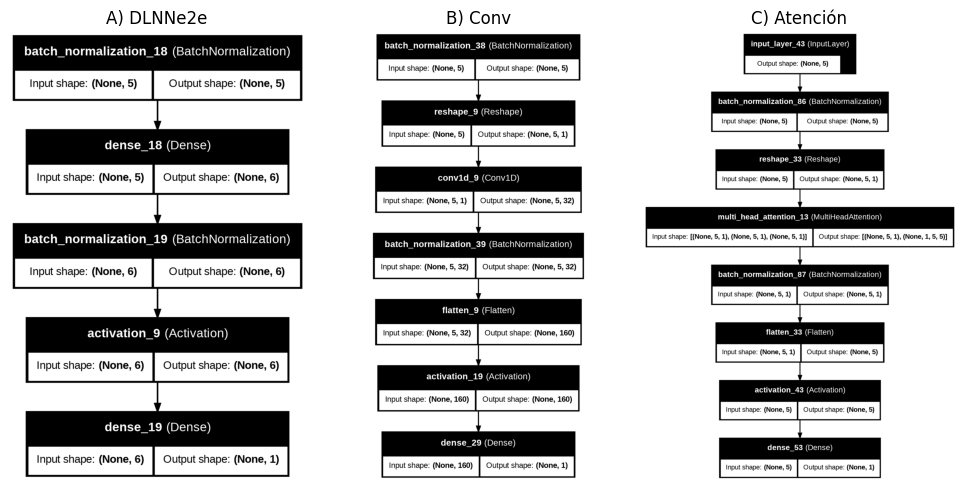

In [39]:
plt.figure(figsize=(10, 5))

# Subplot for DLNNe2e
plt.subplot(1, 3, 1)
plt.title('A) DLNNe2e')
plot_model(DLNNe2e, to_file='model_dlnne2e.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_dlnne2e.png')
plt.imshow(img)
plt.axis('off')

# Subplot for DLNNnorm
plt.subplot(1, 3, 2)
plt.title('B) Conv')
plot_model(conv, to_file='model_conv.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_conv.png')
plt.imshow(img)
plt.axis('off')

# Subplot for DLNNnorm
plt.subplot(1, 3, 3)
plt.title('C) Atención')
plot_model(atencion, to_file='model_atencion.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_atencion.png')
plt.imshow(img)
plt.axis('off')

plt.tight_layout()
plt.show()

La primera comparación que se puede hacer entre los 3 modelos reside en la arquitectura, y en la cantidad de parámetros entrenables. Podemos ver que para cada modelo, la cantidad de parámetros entrenables es:


*   **DLNNe2e**: 65
*   **Conv**: 331
*   **Atención**: 26

Por un lado, notamos que el modelo *Conv* no solo tiene más parámetros entrenables que el modelo *Atención*, sino que también supera considerablemente al modelo original (*DLNNe2e*). Esto implica un mayor costo computacional.
Por otro lado, el modelo *Atención* tiene 26 parámetros entrenables, a comparación de los 65 parámetros correspondientes al modelo original. Esto nos permite concluir que el modelo de atención implica un considerablemente menor costo computacional.



## Tiempo de Inferencia

Aunque el modelo *Atención* tiene menos parámetros entrenables, la capa de atención es más compleja que una capa completamente conectada (FCL), lo que puede incrementar el costo computacional. Sin embargo, dado que en este problema se utilizan únicamente 5 features, la complejidad adicional no debería representar un inconveniente significativo.
De todas formas, para analizar mejor esta diferencia, se calcula el tiempo de inferencia, es decir, el tiempo que tarda cada modelo en realizar una predicción a partir de nuevos datos.

In [41]:
import time

def measure_inference_time(model, X_test):
    start_time = time.time()
    _ = model.predict(X_test)
    end_time = time.time()

    inference_time = end_time - start_time
    return inference_time

# Comparar tiempos de inferencia de los modelos ya entrenados
inference_time_attention = measure_inference_time(atencion, X_test)
inference_time_conv = measure_inference_time(conv, X_test)
inference_time_dlnn = measure_inference_time(DLNNe2e, X_test)

print(f"Tiempo de inferencia del modelo de Atención: {inference_time_attention:.6f} segundos")
print(f"Tiempo de inferencia del modelo Conv: {inference_time_conv:.6f} segundos")
print(f"Tiempo de inferencia del modelo DLNNe2e: {inference_time_dlnn:.6f} segundos")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tiempo de inferencia del modelo de Atención: 0.090407 segundos
Tiempo de inferencia del modelo Conv: 0.094176 segundos
Tiempo de inferencia del modelo DLNNe2e: 0.083896 segundos


El modelo Conv es el que presenta el mayor tiempo de inferencia (0.094176 segundos), lo cual está en línea con su mayor cantidad de parámetros entrenables. Por otro lado, notamos que el tiempo de inferencia del modelo de *Atencion* es de 0.090407 segundos, mientras que para el modelo original presenta el menor tiempo, con 0.0839 segundos. Esto implica que, aunque el modelo *Atención* tiene significativamente menos parámetros entrenables que los otros modelos, la complejidad inherente a la capa de atención provoca que su tiempo de inferencia sea mayor, aunque se mantenga cercano al de un modelo con una estructura más sencilla.

## Attention Scores

In [48]:
print("Shape de attention scores:", len(att_scores[0]))

Shape de attention scores: 22


In [54]:
att_scores_array = np.array(att_scores)  # Shape esperado: (num_splits, batch_size, 1, 5, 5)
print("Shape de att_scores:", att_scores_array.shape)

Shape de att_scores: (10, 22, 1, 5, 5)


<ipython-input-59-9ea50611e24f>:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])


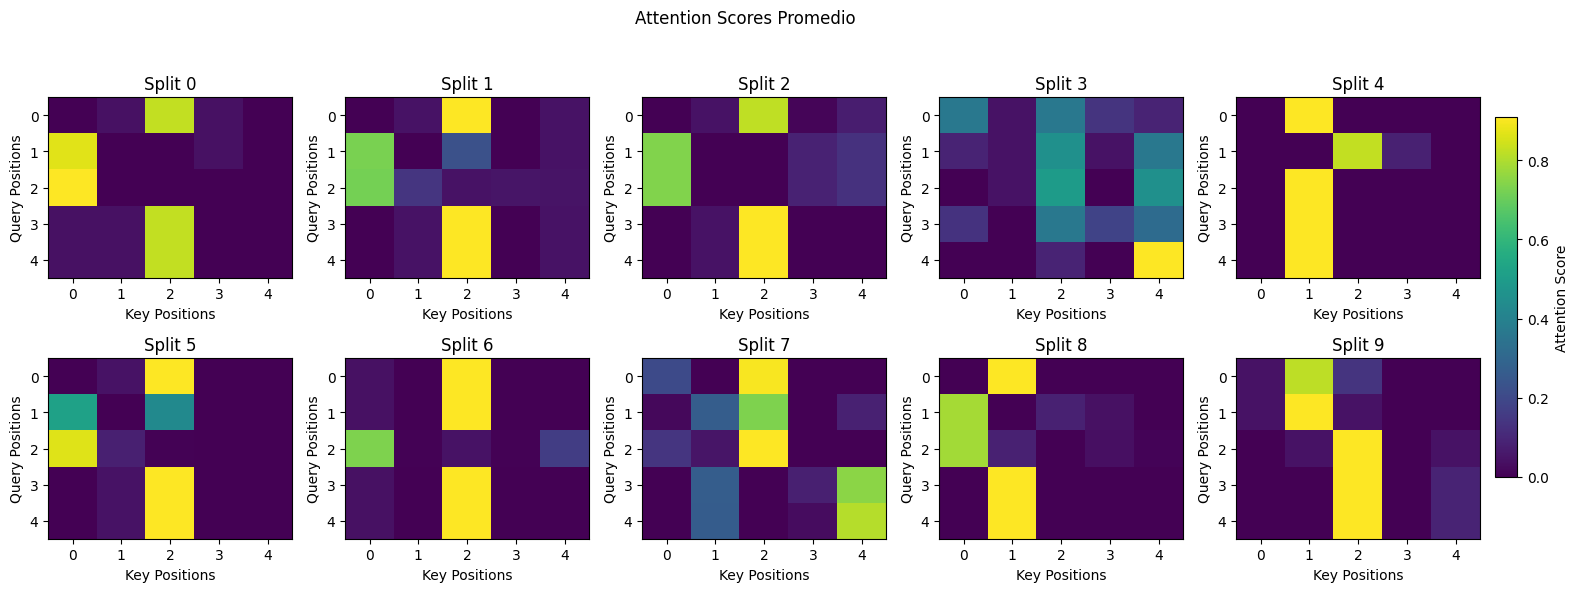

In [59]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
for split_idx in range(10):
  # Promediar sobre todas las muestras en el split
  average_attention = np.mean(att_scores_array[split_idx, :, 0, :, :], axis=0)

  ax = axes[split_idx // 5, split_idx % 5]

  # Graficar el heatmap
  im = ax.imshow(average_attention, cmap="viridis", aspect="auto")
  ax.set_title(f"Split {split_idx}")
  ax.set_xlabel("Key Positions")
  ax.set_ylabel("Query Positions")

fig.suptitle(f"Attention Scores Promedio")
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Agregar una barra de color común
cbar_ax = fig.add_axes([1, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Attention Score")

plt.show()

En la gran mayoría de los splits, la **Key Position** 2, correspondiente a la variable Upos, recibe la mayor atención en todas las **Query Positions** (con excepción de sí mismo). Esto sugiere que la combinación de los demás features con *Upos* es clave para la estimación de *Ueq*. En otras palabras, la presencia de *Upos* parece ser un factor determinante en la predicción de *Ueq*, lo que indica su importancia en el modelo. Este hallazgo es consistente con otros análisis previos, como la inspección de los parámetros de la capa de entrada de **Batch Normalization**, donde se había identificado la relevancia de *Upos* en la estimación de *Ueq*

## Rendimiento de los modelos

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los resultados de los archivos pickle
with open('/content/drive/MyDrive/Embryoxite/original_model_checkpoints/results.pickle', 'rb') as f:
    results_original = pickle.load(f)
with open('/content/drive/MyDrive/Embryoxite/conv_model_checkpoints/results.pickle', 'rb') as f:
    results_conv = pickle.load(f)
with open('/content/drive/MyDrive/Embryoxite/atencion_model_checkpoints/results.pickle', 'rb') as f:
    results_atencion = pickle.load(f)

# Calcular MSE, RMSE, MAE, y R² para cada modelo
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Calcular las métricas para cada modelo y cada split
metrics = {'DLNNe2e': [], 'Conv': [], 'Atencion': []}
att_scores = []
for i in range(10):  # Asumiendo 10 splits
    y_true = results_original[i]['DLNNe2e']['true_value']

    y_pred_dlnne2e = results_original[i]['DLNNe2e']['predictions']
    metrics['DLNNe2e'].append(calculate_metrics(y_true, y_pred_dlnne2e))

    y_pred_conv = results_conv[i]['conv']['predictions']
    metrics['Conv'].append(calculate_metrics(y_true, y_pred_conv))

    y_pred_atencion = results_atencion[i]['atencion']['predictions']
    att_scores.append(results_atencion[i]['atencion']['attention_scores'])
    metrics['Atencion'].append(calculate_metrics(y_true, y_pred_atencion))


df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'MSE': [np.mean([m[0] for m in metrics[model]]) for model in metrics],
    'RMSE': [np.mean([m[1] for m in metrics[model]]) for model in metrics],
    'MAE': [np.mean([m[2] for m in metrics[model]]) for model in metrics],
    'R²': [np.mean([m[3] for m in metrics[model]]) for model in metrics]
})

# Imprimir la tabla
df.head()

,Model,MSE,RMSE,MAE,R²
0,DLNNe2e,147.115634,11.893684,8.435553,0.585099
1,Conv,668.103079,25.366219,21.040251,-0.754830
2,Atencion,609.864221,24.414662,19.918895,-0.613740


Para las 4 métricas utilizadas, notamos que el modelo *DLNNe2e* tiene un mejor rendimiento, ya que tiene un menor error y explica mejor la varianza de los datos. Además, los modelos *Conv* y *Atención* no solo presentan errores más altos, sino que además tienen un R2 negativo, lo que implica que están funcionando peor que simplemente predecir la media de los valores de salida.

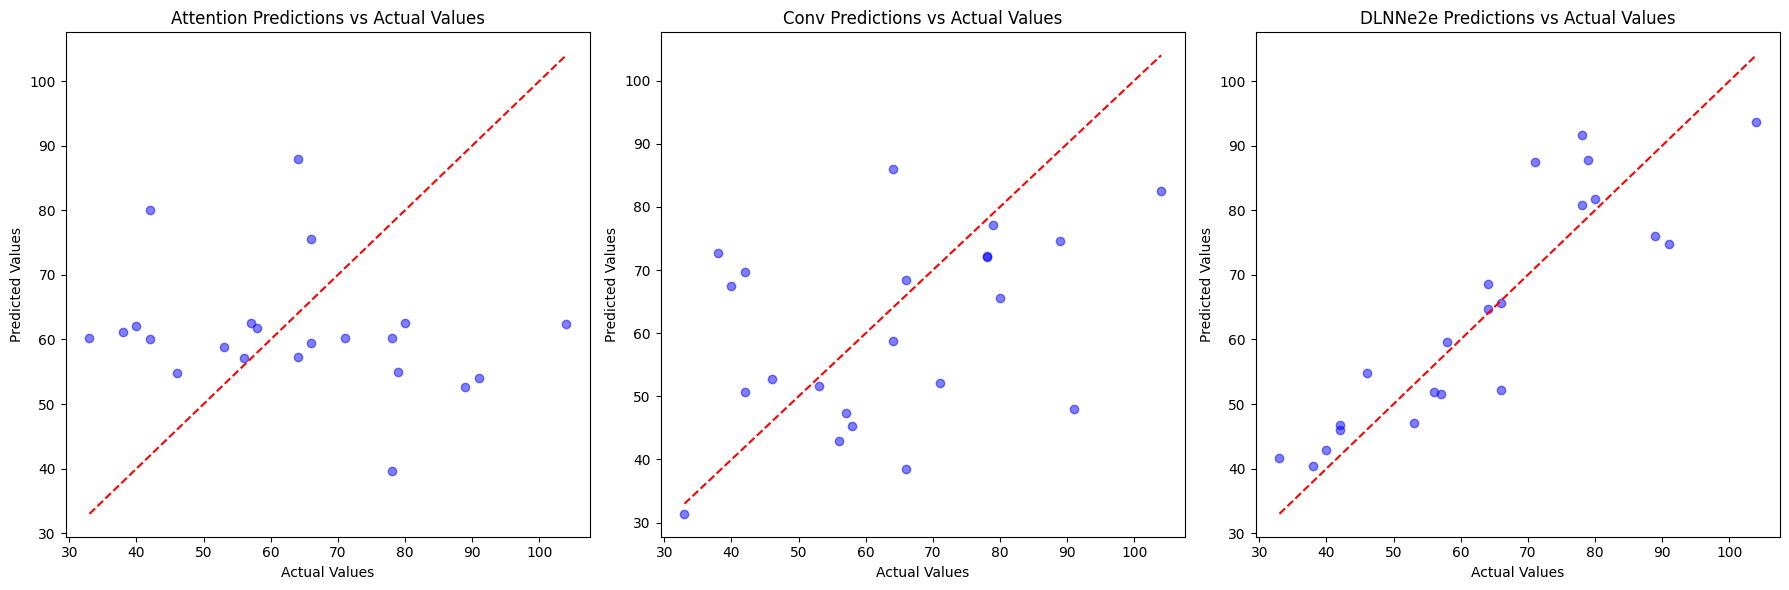

In [43]:
import matplotlib.pyplot as plt

# Crear una figura con 1 fila y 3 columnas de subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Definir los modelos y sus predicciones
models = [
    ("Attention", y_pred_atencion),
    ("Conv", y_pred_conv),
    ("DLNNe2e", y_pred_dlnne2e)
]

# Recorrer cada subplot y graficar
for ax, (model_name, y_pred) in zip(axes, models):
    ax.scatter(y_true, y_pred, color='blue', alpha=0.5)
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    ax.set_title(f'{model_name} Predictions vs Actual Values')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


Estos gráficos coinciden con lo analizado previamente. Vemos que en el caso del modelo *DLNNe2e*, los puntos están más alineados con la línea roja, lo que indica predicciones más precisas. Si bien hay desviaciones, la tendencia general es considerablemente mejor que los otros dos modelos. En los otros dos modelos, vemos puntos dispersos y alejados de la linea roja.

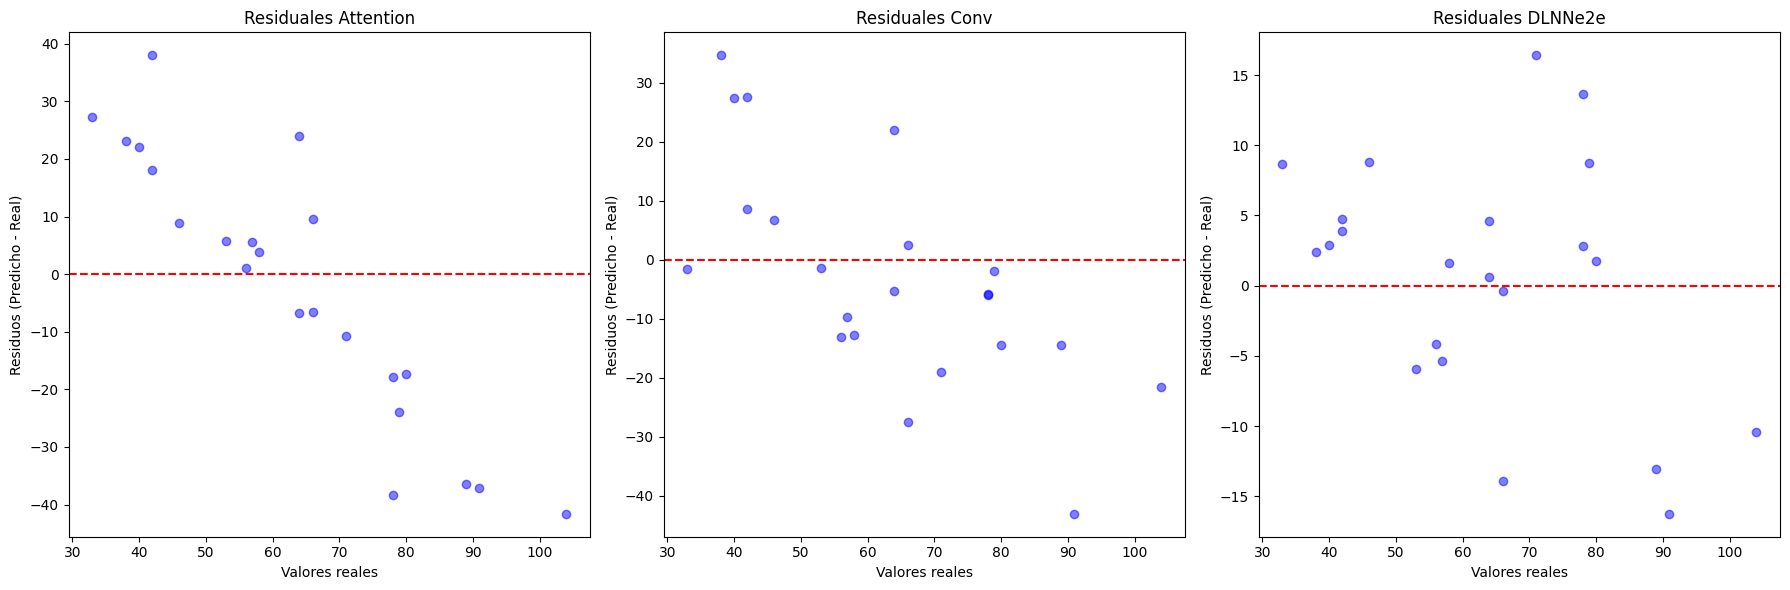

In [44]:
# Crear una figura con 1 fila y 3 columnas de subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Definir los modelos y sus predicciones
models = [
    ("Attention", y_pred_atencion),
    ("Conv", y_pred_conv),
    ("DLNNe2e", y_pred_dlnne2e)
]

for ax, (model_name, y_pred) in zip(axes, models):
    residuals = y_pred - y_true
    ax.scatter(y_true, residuals, color='blue', alpha=0.5)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Residuales {model_name}')
    ax.set_xlabel('Valores reales')
    ax.set_ylabel('Residuos (Predicho - Real)')
plt.tight_layout()
plt.show()

Estos gráficos muestran la diferencia entre los valores predichos y los valores reales para cada modelo. El análisis de estos gráficos coincide con lo que se analizó previamente. En el caso del modelo de *atencion*, hay una gran disperción, lo que indica que el modelo comete errores grandes. Además, hay un patrón de error, ya que para los valores reales bajos, los errores son positivos, y para los altos, los errores son negativos. Esto sugiere que el modelo no capta correctamente la relación entre variables.

El modelo de *convolución*, por otro lado, también muestra una gran variabilidad en los errores pero sin una estructura clara. Si bien no tiene una tendencia de error como el caso anterior, sigue siendo inconsistente.

Por último, los residuales están más concentrados alrededor de la línea 0 del modelo *DLNNe2e*, lo que indica que este modelo puede hacer predicciones más precisas.

En conclusión, el mejor modelo es el *DLNNe2e*, y se demuestra tanto en las métricas evaluadas como en los gráficos. Además, es visible que usar capas convolucionales o de atención en este problema no mejoró el desempeño, sino que lo empeoró. Este tiene sentido por las siguientes razones:


*   El modelo original es un modelo optimizado, para el cual ya se encontró la combinación de parámetros correcta para el problema presentado. En el caso de los otros modelos, se debería encontrar los modelos óptimos para este problema y a partir de ellos, realizar un análisis más comparativo.

*  El conjunto de datos es pequeño y cuenta con pocas características, lo que sugiere que el problema podría no tener una estructura lo suficientemente compleja como para justificar el uso de capas más avanzadas. Esto es relevante, ya que los modelos podrían ser demasiado complejos para el conjunto de datos, lo que aumentaría el riesgo de sobreajuste.




# Conclusiones

Si bien, en teoría, el uso de ambas capas es adecuado para el problema planteado, en la práctica es necesario realizar ciertas adaptaciones para ajustar el modelo al problema o viceversa. En una sección anterior se explicó la utilidad de cada capa, pero ambas siguen siendo demasiado complejas para el conjunto de datos disponible. Para aprovechar mejor sus beneficios, sería recomendable aumentar la cantidad de muestras y/o incluir más características en el conjunto de datos. Además, si se incorporan variables de entrada con un orden intrínseco, el uso de ambas capas tendría aún más sentido.